<a href="https://colab.research.google.com/github/ericdnbn/housing_price_modeling/blob/master/Housing_Price_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import keras
from keras import models, layers
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Functions

def get_results(results):

    '''Prints the mean negative rmse from the model that had the lowest mean rmse'''

    print('The best model parameters produce a mean rmse score on train data of:')
    print(results.cv_results_['mean_train_neg_root_mean_squared_error'][results.best_index_])
    print('')
    print('The best model parameters produce a mean R-squared score on train data of:')
    print(results.cv_results_['mean_train_r2'][results.best_index_])
    print('')
    print('The best model parameters produce a mean rmse score on test data of:')
    print(results.cv_results_['mean_test_neg_root_mean_squared_error'][results.best_index_])
    print('')
    print('The best model parameters produce a mean R-squared score on test data of:')
    print(results.cv_results_['mean_test_r2'][results.best_index_])
    
    
def get_results_preds(y_train, y_train_preds, y_test, y_test_preds):
    
    # Getting R squared scores for training and testing data
    y_tr_r2 = r2_score(y_tr, y_tr_preds)
    y_val_r2 = r2_score(y_val, y_val_preds)

    print(f'R-Squared score for the training data: {y_tr_r2}')
    print('')
    print(f'R-Squared score for the testing data: {y_val_r2}')
    print('')
    print('')

    # Getting Mean Squared Error for training and testing data
    y_tr_rmse = mean_squared_error(y_tr, y_tr_preds, squared = False)
    y_val_rmse = mean_squared_error(y_val, y_val_preds, squared = False)

    print(f'Root Mean Squared Error for the training data: {y_tr_rmse}')
    print('')
    print(f'Root Mean Squared Error for the testing data: {y_val_rmse}')

    
def replace_NaN(df, features, value):
    for feature in features:
        df[feature].replace(np.NaN, value , inplace=True)
        

categories = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

scale_dict = dict(zip(categories, range(0,6)))

def scale_function(category):
    return scale_dict[category]


def map_function(df, features, function):
    '''maps certain categorical variables to numerical values'''
    for feature in features:
        df[feature] = df[feature].map(lambda x : function(str(x)))
        

def get_cv_results(cv):
    train_scores = cv['train_score']
    mean_train_score = cv['train_score'].mean()
    test_scores = cv['test_score']
    mean_test_score = cv['test_score'].mean()
    print(cv)
    print('')
    print(f'CV Train Scores: {train_scores}')
    print('')
    print(f'Mean CV Train Score: {mean_train_score}')
    print('')
    print(f'CV Test Scores: {test_scores}')
    print('')
    print(f'Mean CV Test Score: {mean_test_score}')
    
    
def train_error_distribution(y, y_hat):
    train_error = y - y_hat
    plt.scatter(y_hat, train_error)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Distribution Of Training Error')
    plt.ylabel('Error')
    plt.xlabel('Prediction');
    

def test_error_distribution(y, y_hat):
    test_error = y - y_hat
    plt.scatter(y_hat, test_error)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Distribution Of Testing Error')
    plt.ylabel('Error')
    plt.xlabel('Prediction');
    

def visualize_nn(history, model, x_train, y_train, x_validation, y_validation):

    rmse = np.sqrt(history.history['mse'])
    val_rmse = np.sqrt(history.history['val_mse'])
    
    epochs = range(len(rmse))
    plt.plot(epochs, rmse, 'b-', label='Training RMSE');
    plt.plot(epochs, val_rmse, 'r-.', label='Validation RMSE');
    plt.title('Training And Validation MSE')
    plt.legend()
    plt.figure(figsize=(16,8));

    print('')
    print('Training Evaluation:')
    tr_eval = model.evaluate(x_train, y_train, batch_size=100)
    tr_eval
    print('')
    print('Validation Evaluation:')
    t_eval = model.evaluate(x_validation, y_validation, batch_size=50)
    t_eval
    print('')
    eval_rmse = np.sqrt(tr_eval[1])
    print(f'Train Evaluation RMSE: {eval_rmse}')
    print('')
    eval_val_rmse = np.sqrt(t_eval[1])
    print(f'Validation Evaluation RMSE: {eval_val_rmse}');
    

# EDA

In [3]:
# Loading the data
train_df = pd.read_csv('data/train.csv')

In [4]:
# Lokking at the first five observations in the dataframe with the .head() method
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Looking at the dimensions of the dataframe with the .shape attribute, 1460 observations, 81 columns
train_df.shape

(1460, 81)

In [6]:
# Looking at the data type of the values in each column, as well as the number of non-null values in each column
# Need to check null values to amek decisions about dropping features or imputing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Predictors that need to be dropped, because of too many null values – ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [7]:
# Looking at summary statistics of each column in the dataframe to establish outliers using the .describe() method
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [8]:
# Storing the column of target values as 'target' in memory 
target = train_df['SalePrice']

In [9]:
# Looking at the summary statistics of the target values, can see that the maximum value is an outlier, 
# may want to get rid of that later
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Checking Viability of Linear Model

### Inspecting Linear Relationships Between Predictors And Target


In [10]:
# Storing a list of columns that do not contain values of the data type 'object' in memory as 'num_cols'
# Doing this so I can cehck the relationship between every numerical feature and the target variable
num_cols = list(train_df.select_dtypes(exclude=['object']))
# Checking number of columns so I know how many subplots I need
len(num_cols)

38

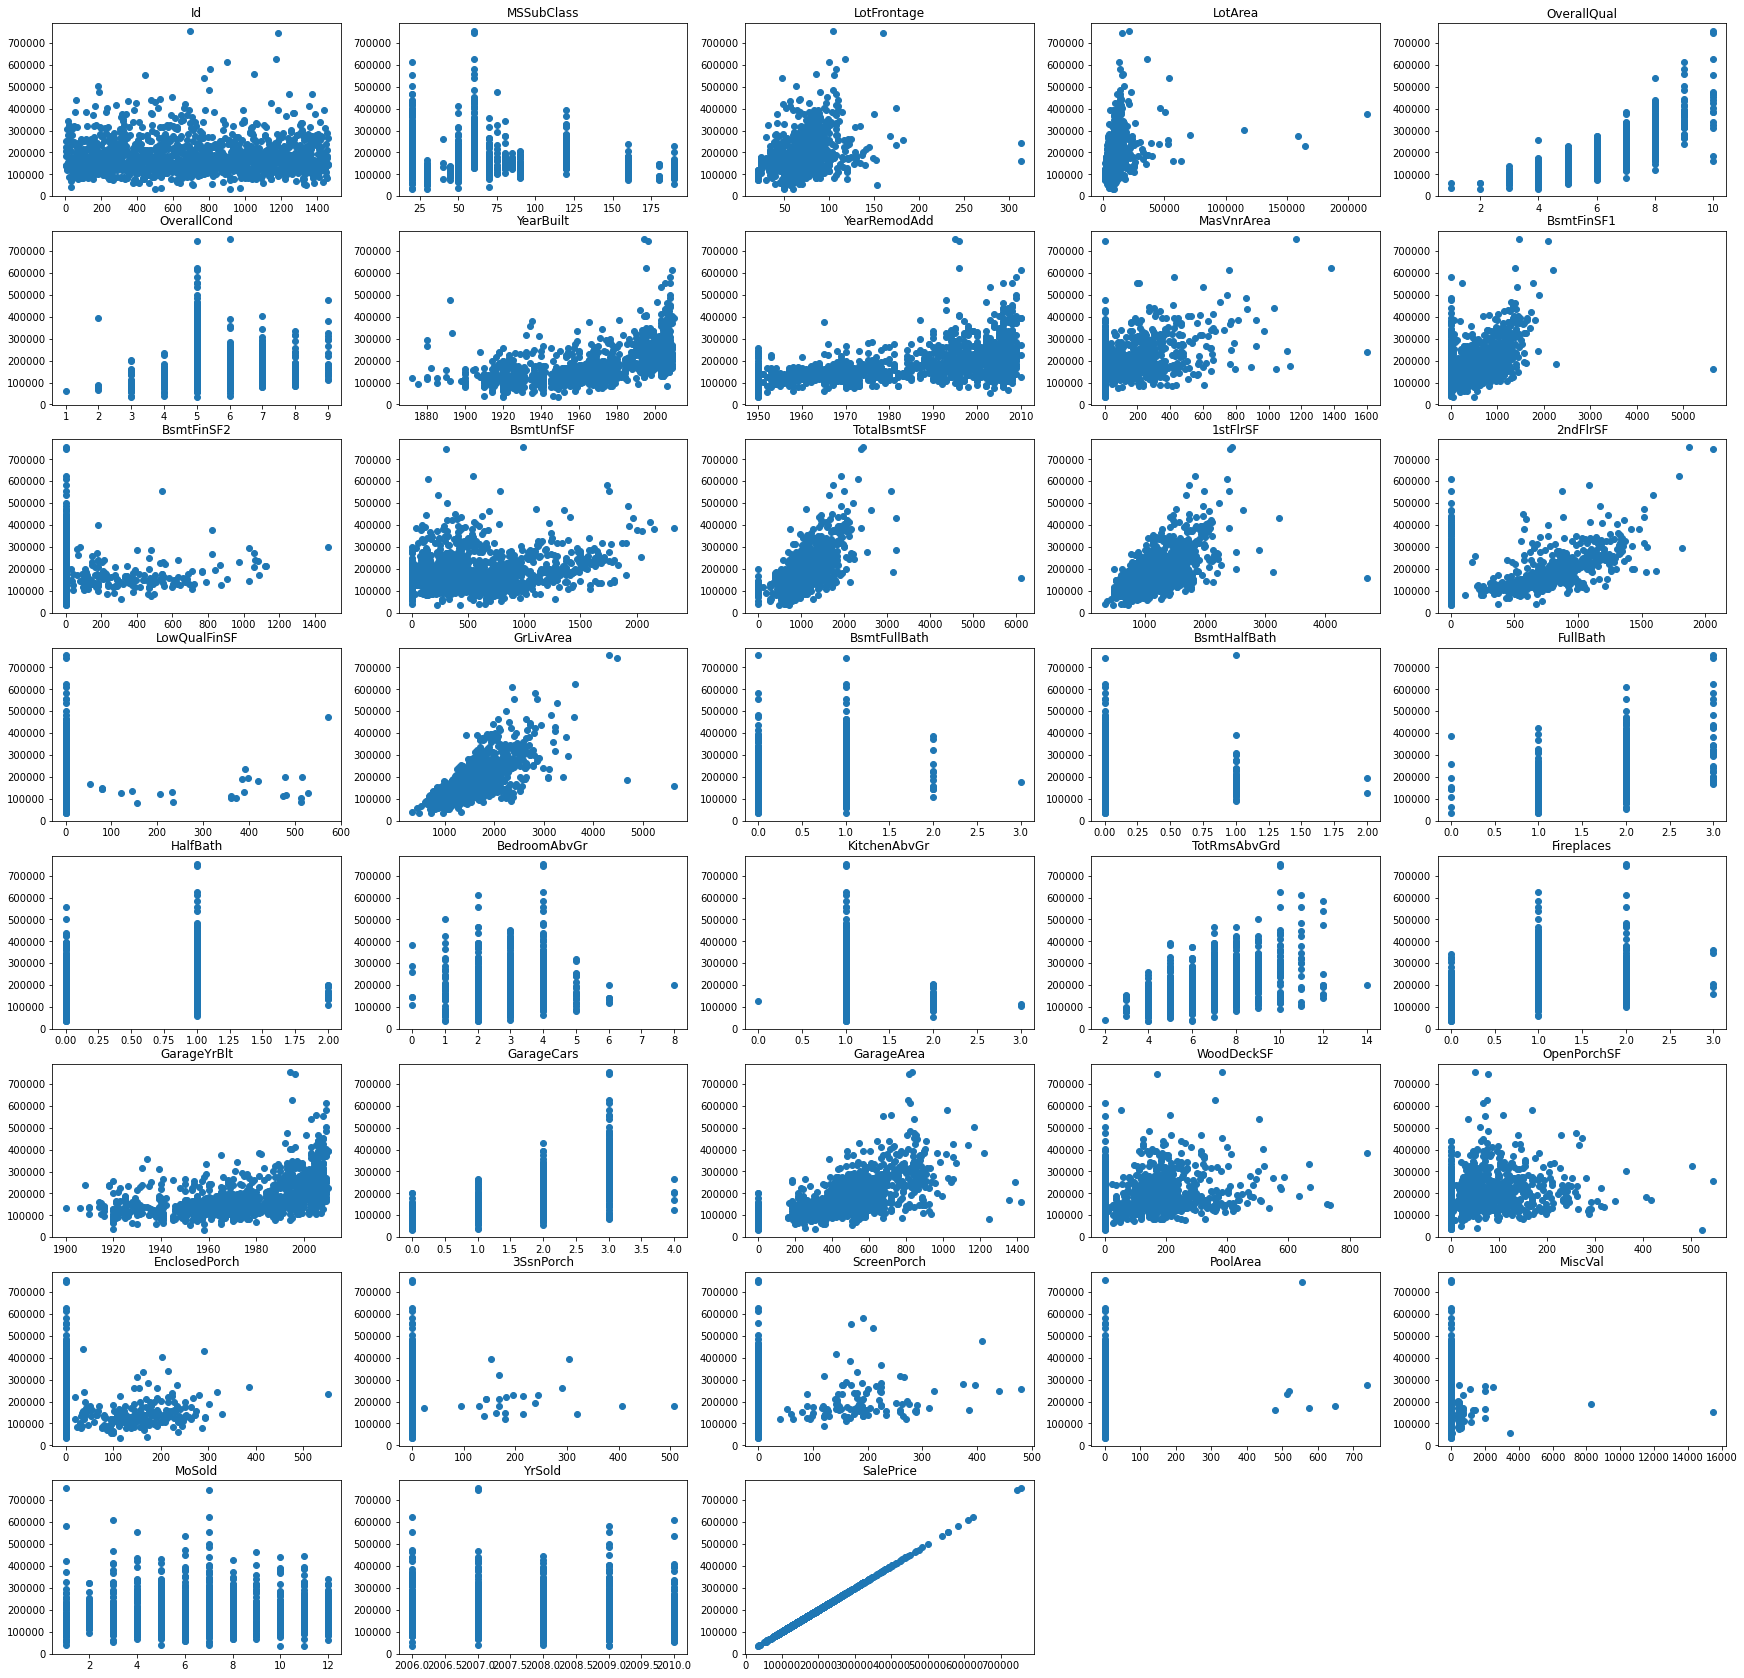

In [11]:
# Storing variables to used in the upcoming for loop
fig = plt.figure(1, figsize=(30,30))
columns = 5
rows = 8
# Looping through the list of columns, plotting each column in a scatter plot against the target variable 
# to check for linearity
for i, col in enumerate(num_cols):
    fig.add_subplot(rows, columns, i+1)
    plt.scatter(train_df[col], train_df['SalePrice'])
    plt.title(col);

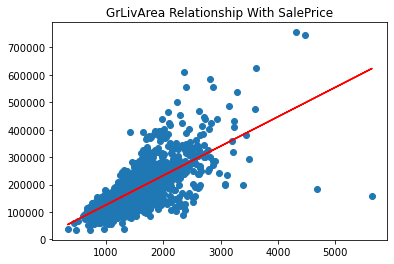

In [12]:
# Plotting a single feature that displays nice linearity with a best fit line to show the relationship
plt.scatter(train_df['GrLivArea'], train_df['SalePrice'])
# Using np.polyfit() returns coefficients, the slope is the value at index 0, 
# the intercept the value at index 1
theta = np.polyfit(train_df['GrLivArea'], train_df['SalePrice'], 1)
# Calculating the y values of the line
line = theta[1] + theta[0]*train_df['GrLivArea']
# Plotting the x values('GrLivArea') against the y values(line)
plt.plot(train_df['GrLivArea'],line, 'r')
plt.title('GrLivArea Relationship With SalePrice');

The independent variables that clearly do not have a linear relationship with the target are 'MSSubClass' and 'KitchensAbvGr'. I will consider dropping these variables during the feature selection stage.

### Checking Multivariate Normality

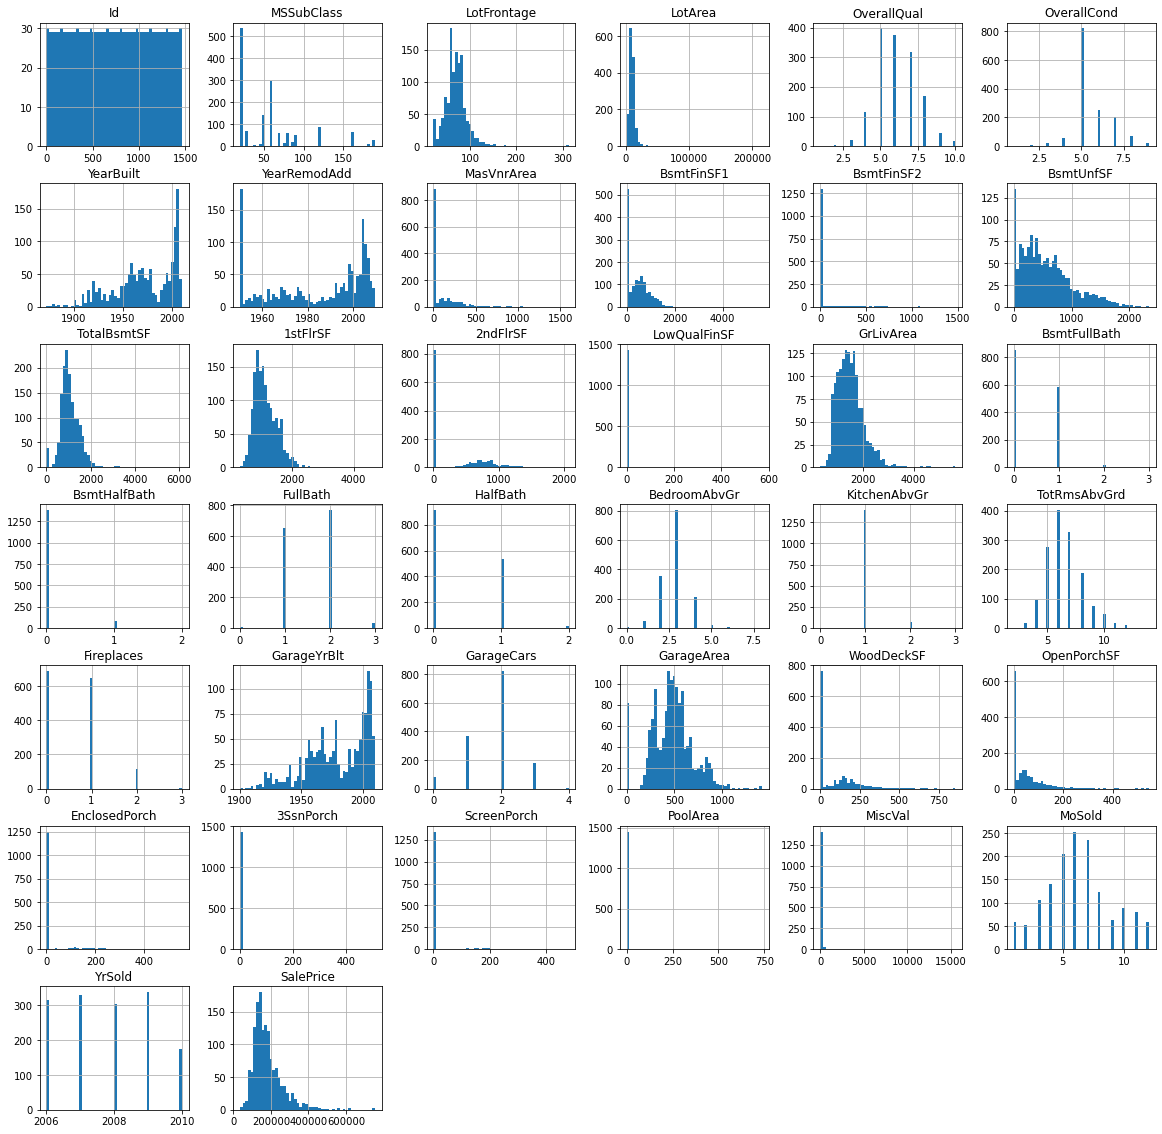

In [13]:
# Checking the distribution of the values in each numerical column
train_df.hist(figsize=(20,20), bins=50);

It appears that many variables in this dataset are slightly non-normally distributed. However, this is most likely an effect of the outliers, which I would like to keep for now in an effort to model the real world. And given that predictors with continous values that are not in units of time, such as 'LotFrontage' and 'LotArea', are mostly normal, I am going to try training models on just a standard scaled raw dataset.


### Checking For Multicollinearity

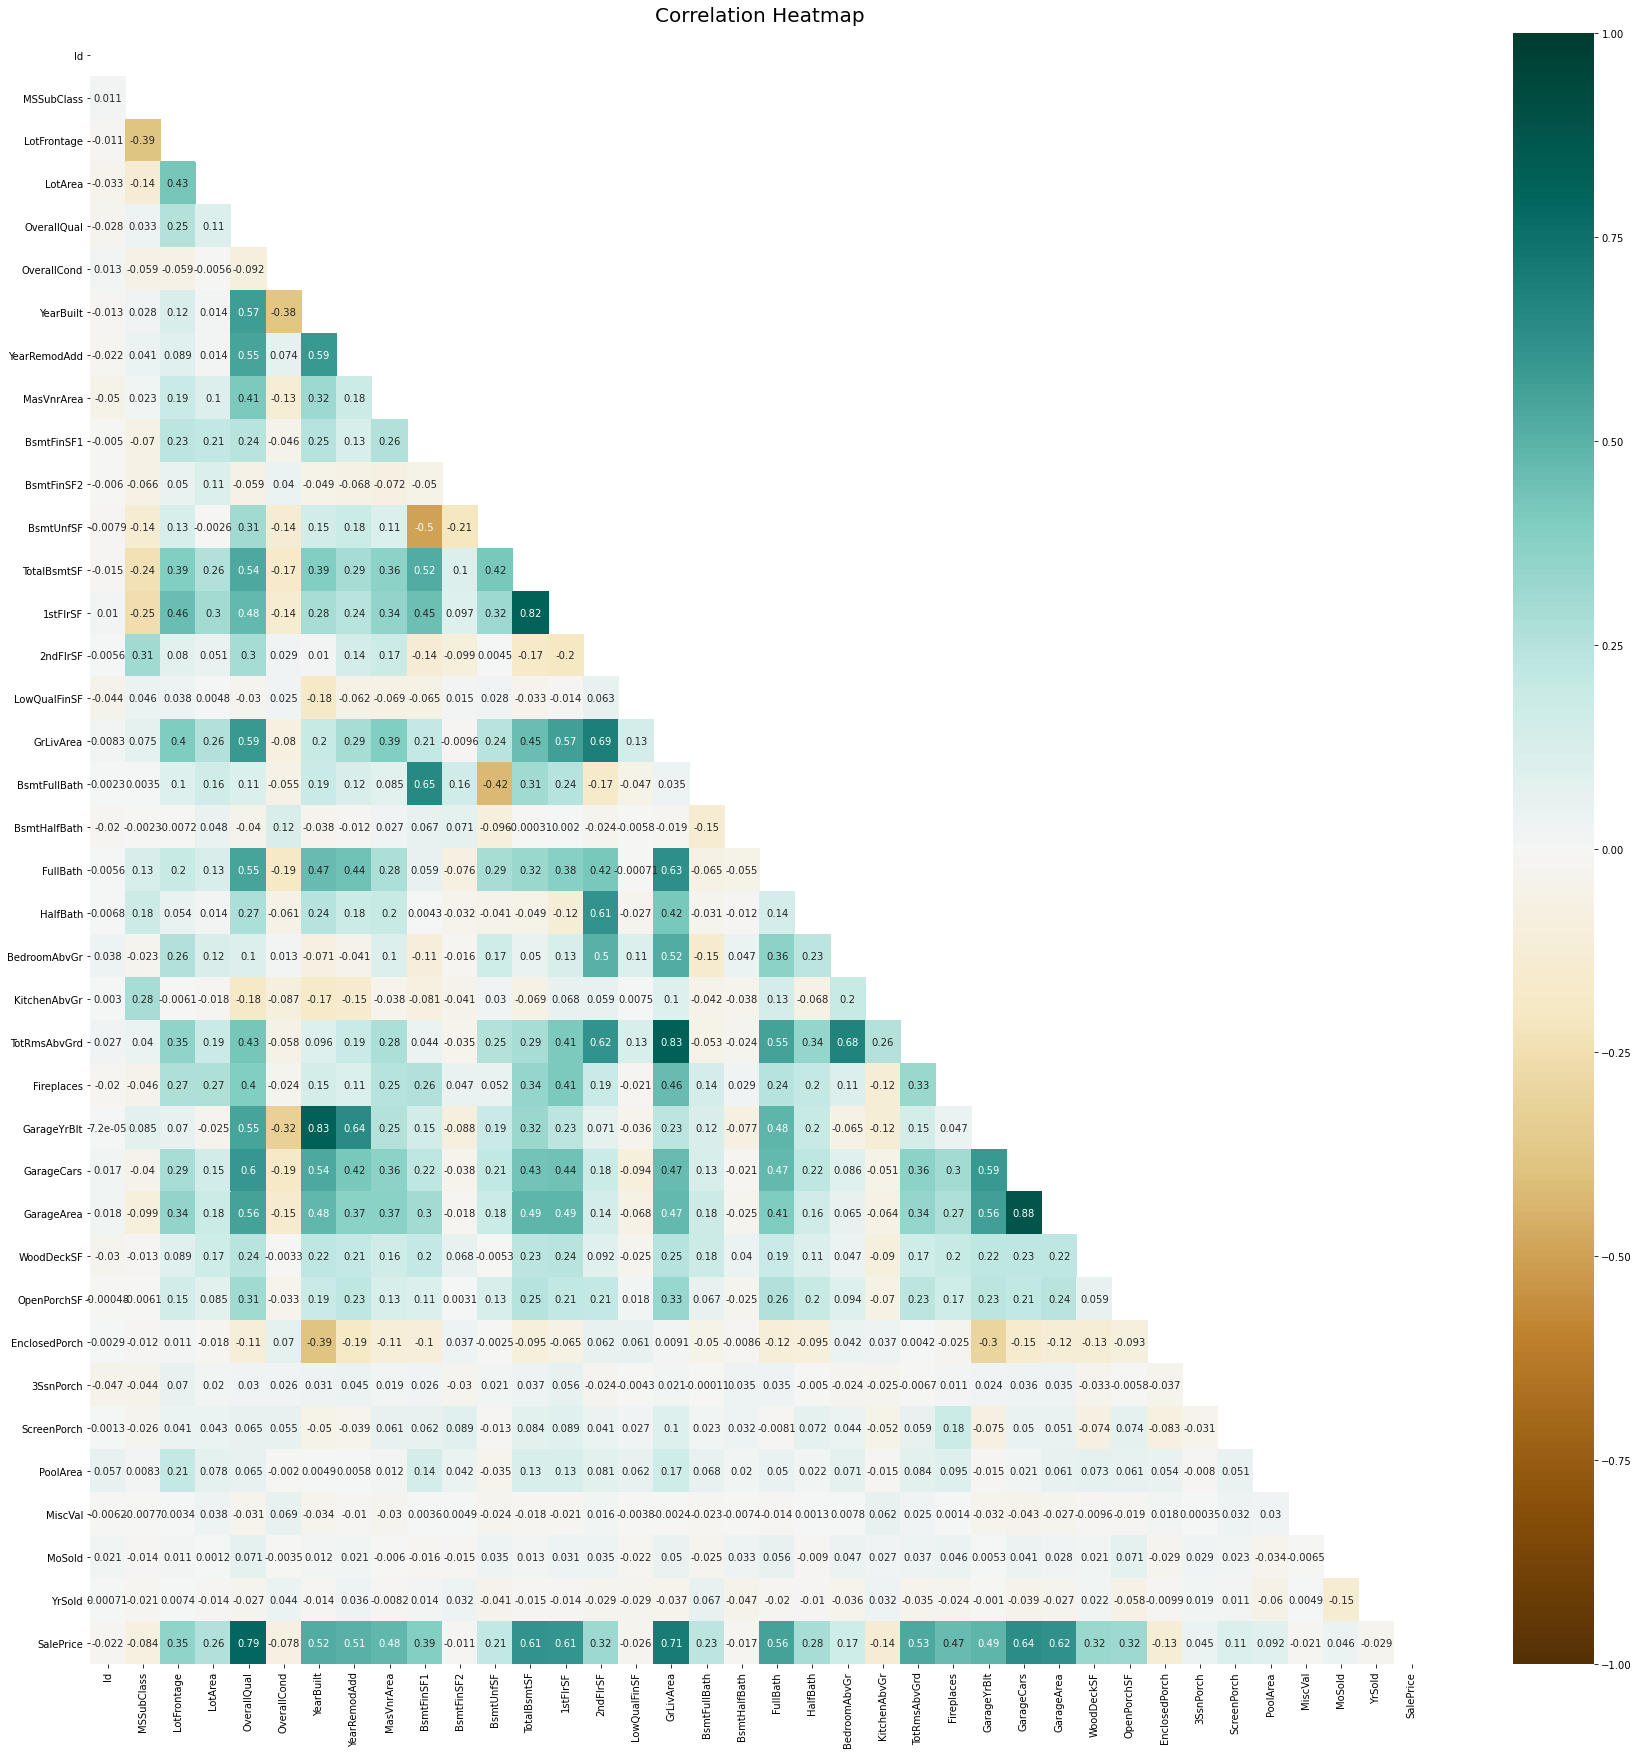

In [14]:
plt.figure(figsize=(30, 30))
mask = np.triu(np.ones_like(train_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

There are a few dark green points on the heatmap indicating a high correlation between two variables. When I start the process of data cleaning, I will take out multicollinear variables.

### Checking Homoscedasticity of Target

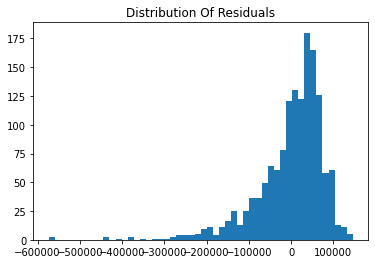

In [15]:
# Using the mean of the target as a theoretical prediction for each observation to calculate baseline residuals
plt.hist((train_df['SalePrice'].mean() - train_df['SalePrice']), bins=50)
plt.title('Distribution Of Residuals');

It is clear that this distribution of baseline residuals skews left, however not terribly. Using linear regression is feasible, though multicollinearity needs to be reduced. I will check the residuals of the first basic linear regression for homoscedasticity.

# Data Preprocessing

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [17]:
# This dataset already contains very little data, and given the description, Lot Frontage is an important variable
# So I am replacing null values of Lot Frontage with the variable mean of the nieghborhood that the observation is in 
# to avoid dropping the 200+ rows of data or dropping the variable entirely
# Credit goes to 'https://www.benjamindornel.com/ames-regression.html'
def impute_lot_frontage(row):
    if np.isnan(row['LotFrontage']):
        neighborhood = row['Neighborhood']
        # Getting the mean lot frontage of the neighborhood where the observation with the nan value is located
        lot_frontage_mean = train_df[train_df['Neighborhood'] == neighborhood]['LotFrontage'].mean()
        row['LotFrontage'] = lot_frontage_mean
    
    return row

In [18]:
train_df = train_df.apply(impute_lot_frontage, axis=1)

In [19]:
# Replacing NaN values in certain garage features to 'U' for Unknown
# Adding an extra value to each feature meaning there will be an addtional column created for each when they 
# are OneHotEncoded, but that is quite worth it
replace_NaN(train_df, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'U')

# Feature Selection And Engineering

In [20]:
# Finding Multicollinear Predictors
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking
train_df_mc = train_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# rename correlation column as cc rather than 0
train_df_mc.columns = 'v1', 'v2', 'corr'

# reset index for future concatenation
train_df_mc.reset_index(inplace=True)

In [21]:
# Takes a row and creates two new rows, one with the correlation between the v1 feature and the target variable, 
# the other with the correlation between the v2 feature and the target variable
# Credit goes to 'https://www.benjamindornel.com/ames-regression.html'
def feat_target(row):
    row['v1_y_corr'] = train_df.corr()['SalePrice'][row['v1']]
    row['v2_y_corr'] = train_df.corr()['SalePrice'][row['v2']]
    return row

In [22]:
train_df_mc = train_df_mc.apply(feat_target, axis=1)

In [23]:
train_df_mc['pairs'] = list(zip(train_df_mc.v1, train_df_mc.v2))

# drop level columns
train_df_mc.drop(columns=['index','v1', 'v2'], inplace = True)

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
train_df_mc.drop_duplicates('corr', inplace=True)

# set index to pairs
train_df_mc.set_index(['pairs'], inplace = True)

In [24]:
multicollinear = train_df_mc[(train_df_mc['corr'] > 0.7) & (train_df_mc['corr'] < 1)]
multicollinear

,corr,v1_y_corr,v2_y_corr
pairs,,,
"(GarageCars, GarageArea)",0.882475,0.640409,0.623431
"(YearBuilt, GarageYrBlt)",0.825667,0.522897,0.486362
"(GrLivArea, TotRmsAbvGrd)",0.825489,0.708624,0.533723
"(1stFlrSF, TotalBsmtSF)",0.819530,0.605852,0.613581
"(SalePrice, OverallQual)",0.790982,1.000000,0.790982
"(SalePrice, GrLivArea)",0.708624,1.000000,0.708624


GaragesCars is more highly correlated with SalePrice than GarageArea, so GarageArea will be dropped.

YearBuilt is more highly correlated with SalePrice than GarageYrBlt, so GarageYrBlt will be dropped.

GrLivArea is more highly correlated with SalePrice than TotRmsAbvGrd, so TotRmsAbvGrd will be dropped.

TotBsmtSF is more highly correlated with SalePrice than 1stFlrSF, so 1stFlrSF will be dropped.

In [524]:
# Dropping 'Id' column
train_df.drop('Id', axis=1, inplace=True)

In [525]:
# Dropping predictors with too many null values
train_df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [526]:
# Dropping multicollinear predictors
train_df.drop(['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF'], axis=1, inplace=True)

In [527]:
# Dropping low variance predictors, because they will have little effect on the model
var = train_df.var().sort_values(ascending=True)
low_var = var[var <.1]
low_var = list(low_var.index)
train_df.drop(low_var, axis=1, inplace=True)

In [528]:
# Dropping predictors not linearly related to the target
train_df.drop('MSSubClass', axis=1, inplace=True)

In [529]:
# Dropping remaining null values
train_df.dropna(inplace=True)

In [530]:
# Turning these predictors from categorical into numerical
map_function(train_df, ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'], scale_function)

In [531]:
# Combining the weaker mid_var predictors to try and give them more predictive power
train_df['Bath_Fireplaces'] = train_df['Fireplaces'] + train_df['FullBath']

In [532]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1459
Data columns (total 69 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSZoning         1412 non-null   object 
 1   LotFrontage      1412 non-null   float64
 2   LotArea          1412 non-null   int64  
 3   Street           1412 non-null   object 
 4   LotShape         1412 non-null   object 
 5   LandContour      1412 non-null   object 
 6   Utilities        1412 non-null   object 
 7   LotConfig        1412 non-null   object 
 8   LandSlope        1412 non-null   object 
 9   Neighborhood     1412 non-null   object 
 10  Condition1       1412 non-null   object 
 11  Condition2       1412 non-null   object 
 12  BldgType         1412 non-null   object 
 13  HouseStyle       1412 non-null   object 
 14  OverallQual      1412 non-null   int64  
 15  OverallCond      1412 non-null   int64  
 16  YearBuilt        1412 non-null   int64  
 17  YearRemodAdd  

In [533]:
train_df.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bath_Fireplaces
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,2,2008,WD,Normal,208500,2
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,5,2007,WD,Normal,181500,3
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2008,WD,Normal,223500,3
3,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,0,0,0,0,2,2006,WD,Abnorml,140000,2
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,12,2008,WD,Normal,250000,3


# Modeling

## Baseline Models 

### *disclaimer* *
It is hard to say with any certainty how the values imputed to the lot frontage variable will effect the results of the models

### Note: I am using recursive feature elimination prior to fitting

In [578]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [579]:
categorical_cols = x_train.select_dtypes('object')
numerical_cols = x_train.select_dtypes(exclude=['object'])

numerical_transformer = Pipeline(steps=[('ss', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])


transformer = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_cols.columns),
                                              ('categorical', categorical_transformer, categorical_cols.columns) 
                                             ])

#cat_transformer = ColumnTransformer(transformers=[('categorical', categorical_trans, categorical_cols.columns)])

In [580]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3)

# Transforming x_tr and x_val separately to avoid data leakage
x_tr = transformer.fit_transform(x_tr)
x_val = transformer.transform(x_val)


# Reducing Overfitting
rfe = RFE(LinearRegression(normalize=False), n_features_to_select=75)
x_tr = rfe.fit_transform(x_tr, y_tr)
x_val = rfe.transform(x_val)


# Instantiating and fitting model
linreg =  LinearRegression(normalize=False)
results = linreg.fit(x_tr, y_tr)


# Getting Predictions
y_tr_preds = results.predict(x_tr)
y_val_preds = results.predict(x_val)

In [581]:
get_results_preds(y_tr, y_tr_preds, y_val, y_val_preds)

R-Squared score for the training data: 0.9011203723473886

R-Squared score for the testing data: 0.8108101837772864


Root Mean Squared Error for the training data: 24378.368158032215

Root Mean Squared Error for the testing data: 36611.07878134237


## Analysis:

The baseline model using recursive feature elimination appears to have fit fairly well. I am going to check for homoskedasticity and then cross validate the model.

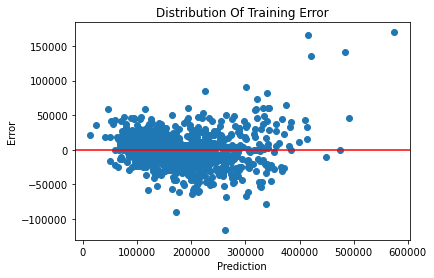

In [582]:
train_error_distribution(y_tr, y_tr_preds)

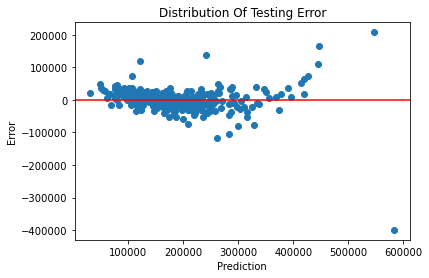

In [583]:
test_error_distribution(y_val, y_val_preds)

It appears that for the most part, the test residuals pass the check for homoscedasticity

In [584]:
rfe = RFE(LinearRegression(normalize=False), n_features_to_select=75)
x_train = transformer.fit_transform(x_train)
x_train = rfe.fit_transform(x_train, y_train)
cv = cross_validate(linreg, x_train, y_train, scoring='r2', cv=5, return_train_score=True)
get_cv_results(cv)

{'fit_time': array([0.03184414, 0.04104424, 0.03518486, 0.03032088, 0.03448009]), 'score_time': array([0.00073886, 0.00060964, 0.00075006, 0.00127196, 0.00053477]), 'test_score': array([0.87173715, 0.82297199, 0.80113393, 0.86038515, 0.68988316]), 'train_score': array([0.88614528, 0.89213888, 0.89983384, 0.89158741, 0.89097417])}

CV Train Scores: [0.88614528 0.89213888 0.89983384 0.89158741 0.89097417]

Mean CV Train Score: 0.8921359185194845

CV Test Scores: [0.87173715 0.82297199 0.80113393 0.86038515 0.68988316]

Mean CV Test Score: 0.8092222755302014


## Linear Regression With l2 Regularization

In [481]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [45]:
ridge_pipeline = Pipeline(steps=[('trans', transformer),
                                 ('rfe', RFE(LinearRegression(normalize=False), n_features_to_select=75)),
                                 ('model', Ridge(random_state=42))])

ridge_grid = {'model__alpha': [10.0, 25.0, 50.0, 75.0],
              'model__normalize': [False],
              'model__max_iter': [500, 2000],
              'model__tol': [.001, .0001],
              'model__solver': ['auto']}

ridge_gs = GridSearchCV(ridge_pipeline, 
                        ridge_grid, 
                        scoring=['neg_root_mean_squared_error', 'r2'], 
                        refit='neg_root_mean_squared_error', 
                        cv=5, 
                        verbose=3,
                        return_train_score=True)

In [46]:
results = ridge_gs.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-31217.429, test=-25914.247), r2=(train=0.849, test=0.879), total=  12.7s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.7s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-30524.788, test=-33537.502), r2=(train=0.850, test=0.828), total=  13.5s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.3s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-30825.116, test=-34914.931), r2=(train=0.840, test=0.839), total=  14.0s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-31303.677, test=-28989.172), r2=(train=0.850, test=0.838), total=  12.0s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-27152.855, test=-47557.427), r2=(train=0.882, test=0.650), total=  11.6s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=10.0, mo

[CV]  model__alpha=25.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-32870.346, test=-29208.105), r2=(train=0.835, test=0.836), total=  12.0s
[CV] model__alpha=25.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=25.0, model__max_iter=500, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-28258.292, test=-48009.875), r2=(train=0.872, test=0.643), total=  12.3s
[CV] model__alpha=25.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=25.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-32620.709, test=-26404.022), r2=(train=0.835, test=0.874), total=  12.4s
[CV] model__alpha=25.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001 
[CV]  model__alpha=25.

[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.001, neg_root_mean_squared_error=(train=-29298.070, test=-48484.510), r2=(train=0.862, test=0.636), total=  11.5s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-33832.205, test=-27092.654), r2=(train=0.823, test=0.867), total=  12.5s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001, neg_root_mean_squared_error=(train=-33143.478, test=-34074.794), r2=(train=0.823, test=0.823), total=  14.1s
[CV] model__alpha=50.0, model__max_iter=2000, model__normalize=False, model__solver=auto, model__tol=0.0001 
[CV]  model__alph

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 17.9min finished


In [47]:
results.best_params_

{'model__alpha': 10.0,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__solver': 'auto',
 'model__tol': 0.001}

In [48]:
results.best_score_

-34182.65570655737

In [49]:
get_results(results)

The best model parameters produce a mean rmse score on train data of:
-30204.77303842335

The best model parameters produce a mean R-squared score on train data of:
0.8542529575044672

The best model parameters produce a mean rmse score on test data of:
-34182.65570655737

The best model parameters produce a mean R-squared score on test data of:
0.8068734112651119


### Analysis:

The best parameters for this Ridge regression(linear regression with l2 regularization) were an alpha value of 10.0, maximum iterations of 500, and .001 tol, the default tolerance value.

The best model is slightly overfit to the training data with relation to the validation data, but not too overfit in the broad scope.

## Linear Regressions With l1 Regularization

In [53]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [56]:
lasso_pipeline = Pipeline(steps=[('trans', transformer),
                                 ('rfe', RFE(LinearRegression(normalize=False), n_features_to_select=75)),
                                 ('model', Lasso(random_state=62))])

lasso_grid = {'model__alpha': [10.0, 25.0, 50.0],
              'model__normalize': [False],
              'model__max_iter': [500, 1000],
              'model__tol': [.001, .0001],
              'model__selection': ['cyclic', 'random']}

lasso_gs = GridSearchCV(lasso_pipeline, 
                        lasso_grid, 
                        scoring=['neg_root_mean_squared_error', 'r2'], 
                        refit='neg_root_mean_squared_error', 
                        cv=5, 
                        verbose=3,
                        return_train_score=True)

In [57]:
lasso_results = lasso_gs.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-26143.069, test=-26060.877), r2=(train=0.894, test=0.877), total=  12.4s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-25728.947, test=-35061.192), r2=(train=0.893, test=0.812), total=  13.7s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.2s remaining:    0.0s


[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-23926.139, test=-42020.850), r2=(train=0.904, test=0.767), total=  14.2s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-26299.722, test=-29690.450), r2=(train=0.894, test=0.830), total=  12.1s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-25098.740, test=-48333.786), r2=(train=0.899, test=0.638), total=  11.5s
[CV] model__alpha=10.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model__tol=0.000

[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-23925.210, test=-42044.563), r2=(train=0.904, test=0.767), total=  13.9s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-26299.450, test=-29683.108), r2=(train=0.894, test=0.830), total=  12.0s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001 
[CV]  model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.0001, neg_root_mean_squared_error=(train=-25097.907, test=-48338.065), r2=(train=0.899, test=0.638), total=  11.4s
[CV] model__alpha=10.0, model__max_iter=1000, model__normalize=False, model__selection=random, model

[CV]  model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-24264.195, test=-40035.464), r2=(train=0.901, test=0.789), total=  13.8s
[CV] model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-26522.104, test=-29270.425), r2=(train=0.892, test=0.835), total=  11.9s
[CV] model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001 
[CV]  model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.001, neg_root_mean_squared_error=(train=-25362.586, test=-47985.344), r2=(train=0.897, test=0.644), total=  11.8s
[CV] model__alpha=25.0, model__max_iter=500, model__normalize=False, model__selection=random, model__tol=0.000

[CV]  model__alpha=25.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-24258.713, test=-40075.207), r2=(train=0.901, test=0.788), total=  14.1s
[CV] model__alpha=25.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=25.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-26522.548, test=-29271.768), r2=(train=0.892, test=0.835), total=  12.0s
[CV] model__alpha=25.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001 
[CV]  model__alpha=25.0, model__max_iter=1000, model__normalize=False, model__selection=random, model__tol=0.0001, neg_root_mean_squared_error=(train=-25359.605, test=-47994.151), r2=(train=0.897, test=0.643), total=  11.7s
[CV] model__alpha=50.0, model__max_iter=500, model__normalize=False, model__selection=cyclic, model_

[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-24846.652, test=-38022.554), r2=(train=0.896, test=0.809), total=  14.2s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-26956.076, test=-28929.463), r2=(train=0.889, test=0.839), total=  12.0s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001 
[CV]  model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol=0.001, neg_root_mean_squared_error=(train=-25803.443, test=-47533.410), r2=(train=0.893, test=0.650), total=  11.4s
[CV] model__alpha=50.0, model__max_iter=1000, model__normalize=False, model__selection=cyclic, model__tol

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 26.5min finished


In [58]:
lasso_results.best_params_

{'model__alpha': 50.0,
 'model__max_iter': 500,
 'model__normalize': False,
 'model__selection': 'random',
 'model__tol': 0.0001}

In [59]:
get_results(lasso_results)

The best model parameters produce a mean rmse score on train data of:
-26144.798791128233

The best model parameters produce a mean R-squared score on train data of:
0.8911157755585011

The best model parameters produce a mean rmse score on test data of:
-34873.93932767444

The best model parameters produce a mean R-squared score on test data of:
0.8001131523090838


### Analysis:
The best parameters for this Lasso regression(linear regression with l1 regularization) were an alpha value of 50.0, maximum iterations of 500, and a tolerance of .0001 tol.

The best model is fairly overfit to the training data with relation to the validation data, though only slightly overfit broadly.

### Note: I tested an elasticnet regression in a scratch notebook and it performed terribly, so I am not running it here. If you want to see the results, please reference the other notebook.

## Decision Tree Regression

In [60]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [61]:
dt_pipeline = Pipeline(steps=[('trans', transformer),
                              ('rfe', RFE(LinearRegression(normalize=False), n_features_to_select=75)),
                              ('model', DecisionTreeRegressor(random_state=92))])

dt_grid = {'model__criterion': ['mse', 'mae'],
           'model__splitter': ['best'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2, 12],
           'model__min_samples_leaf': [1, 3],
           'model__max_features': ['auto']}

dt_gs = GridSearchCV(dt_pipeline, 
                     dt_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=5, 
                     verbose=3,
                     return_train_score=True)

In [62]:
dt_results = dt_gs.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-268.614, test=-39189.359), r2=(train=1.000, test=0.723), total=  13.9s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-685.506, test=-51339.711), r2=(train=1.000, test=0.598), total=  13.6s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.5s remaining:    0.0s


[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-374.662, test=-38833.158), r2=(train=1.000, test=0.801), total=  14.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-655.318, test=-41827.826), r2=(train=1.000, test=0.663), total=  12.1s
[CV] model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squa

[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-14161.032, test=-35240.820), r2=(train=0.966, test=0.836), total=  14.2s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-14538.939, test=-39911.464), r2=(train=0.968, test=0.693), total=  12.0s
[CV] model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_er

[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-374.662, test=-41113.049), r2=(train=1.000, test=0.777), total=  14.4s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-655.318, test=-42771.555), r2=(train=1.000, test=0.648), total=  12.0s
[CV] model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squa

[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-13472.008, test=-41550.677), r2=(train=0.969, test=0.772), total=  14.1s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_error=(train=-15729.373, test=-39939.546), r2=(train=0.962, test=0.693), total=  12.8s
[CV] model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best 
[CV]  model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__splitter=best, neg_root_mean_squared_er

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 17.4min finished


In [63]:
dt_results.best_params_

{'model__criterion': 'mse',
 'model__max_depth': 10,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 12,
 'model__splitter': 'best'}

In [64]:
get_results(dt_results)

The best model parameters produce a mean rmse score on train data of:
-23483.469430541732

The best model parameters produce a mean R-squared score on train data of:
0.9118110885672543

The best model parameters produce a mean rmse score on test data of:
-38651.694073440085

The best model parameters produce a mean R-squared score on test data of:
0.760553933795492


### Analysis:

The best parameters for the decision tree regressor were the absolute error for split criterion, a max model depth set to 10(could be interesting to play with this value in the future), a min samples leaf value of 3, a min samples split value of 12, and the 'best' splitter method.

The best model in the grid is considerably overfit to the training data both relative to the validation data as well as to the train set.

## Random Forest Regression

In [65]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [66]:
rf_pipeline = Pipeline(steps=[('trans', transformer),
                              ('rfe', RFE(LinearRegression(normalize=False), n_features_to_select=75)),
                              ('model', RandomForestRegressor(random_state=100))])

rf_grid = {'model__n_estimators': [50, 250],
           'model__criterion': ['mse', 'mae'],
           'model__max_depth': [None, 10],
           'model__min_samples_split': [2],
           'model__min_samples_leaf': [1, 3],
           'model__max_features': ['auto'],
           'model__ccp_alpha': [0.0]}

rf_gs = GridSearchCV(rf_pipeline, 
                     rf_grid, 
                     scoring=['neg_root_mean_squared_error', 'r2'], 
                     refit='neg_root_mean_squared_error', 
                     cv=5, 
                     verbose=3,
                     return_train_score=True)

In [67]:
rf_results = rf_gs.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-13053.776, test=-28794.846), r2=(train=0.974, test=0.850), total=  13.3s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12898.673, test=-34218.859), r2=(train=0.973, test=0.821), total=  15.2s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   28.6s remaining:    0.0s


[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-12090.817, test=-32258.990), r2=(train=0.975, test=0.863), total=  14.8s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-13196.930, test=-28953.461), r2=(train=0.973, test=0.839), total=  12.7s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=None,

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-14494.685, test=-28821.967), r2=(train=0.968, test=0.850), total=  14.1s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-15066.044, test=-33871.321), r2=(train=0.963, test=0.825), total=  14.7s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__ma

[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250, neg_root_mean_squared_error=(train=-22418.412, test=-27515.149), r2=(train=0.923, test=0.854), total=  13.9s
[CV] model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250 
[CV]  model__ccp_alpha=0.0, model__criterion=mse, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250, neg_root_mean_squared_error=(train=-19503.741, test=-37885.664), r2=(train=0.939, test=0.778), total=  13.6s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=50 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, mo

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250, neg_root_mean_squared_error=(train=-22554.080, test=-33328.078), r2=(train=0.918, test=0.830), total=  31.3s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250, neg_root_mean_squared_error=(train=-22206.331, test=-35031.057), r2=(train=0.917, test=0.838), total=  36.6s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=N

[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=50, neg_root_mean_squared_error=(train=-21829.599, test=-38593.023), r2=(train=0.924, test=0.769), total=  15.4s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250, neg_root_mean_squared_error=(train=-21444.929, test=-28187.943), r2=(train=0.929, test=0.857), total=  30.5s
[CV] model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=3, model__min_samples_split=2, model__n_estimators=250 
[CV]  model__ccp_alpha=0.0, model__criterion=mae, model__max_depth=10, model_

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 27.1min finished


It seems that as the model iterates through more candidates, it is beginning to overfit less.

However, it appears that there is at least one fold per candidate that returns an r-squared value below .08. This could potentially be caused by model overfitting on the outliers.

The 'poisson' criteria seems to be resulting in significant overfitting as the train r-squared scores are ~.96 while the validation r-squared scores are between 0.8 and 0.6 for the most part.


In [70]:
rf_results.best_params_

{'model__ccp_alpha': 0.0,
 'model__criterion': 'mse',
 'model__max_depth': None,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 250}

In [71]:
get_results(rf_results)

The best model parameters produce a mean rmse score on train data of:
-12115.373235799616

The best model parameters produce a mean R-squared score on train data of:
0.9765943742612325

The best model parameters produce a mean rmse score on test data of:
-31515.990302817292

The best model parameters produce a mean R-squared score on test data of:
0.8402221513439431


### Analysis:

The best parameters for the random forest regressor were the absolute error for split criterion, a max model depth of none, a min samples leaf value of 1, a min samples split value of 2, and n_estimators 150.

The best model in the grid is significantly overfit to the training data both relative to the validation data, and more broadly.

## XGBoost Regressor

In [149]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [150]:
xgb_pipeline = Pipeline(steps=[('trans', transformer),
                               ('rfe', RFE(LinearRegression(normalize=False), n_features_to_select=75)),
                               ('model', XGBRegressor(random_state=42))])

xgb_grid = {'model__n_estimators': [250, ],
            'model__max_depth': [None, 10],
            'model__booster' : ['gbtree', 'gblinear', 'dart'],
            'model__reg_alpha' : [.01, 1.0],
            'model__reg_lambda' : [75.0, 100.0]}

xgb_gs = GridSearchCV(xgb_pipeline, 
                      xgb_grid, 
                      scoring=['neg_root_mean_squared_error', 'r2'], 
                      refit='neg_root_mean_squared_error', 
                      cv=5, 
                      verbose=3,
                      return_train_score=True)

In [151]:
xgb_results = xgb_gs.fit(x_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-8806.488, test=-27474.891), r2=(train=0.988, test=0.864), total=  13.0s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-10309.400, test=-36896.248), r2=(train=0.983, test=0.792), total=  13.8s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.8s remaining:    0.0s


[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-10069.150, test=-32738.183), r2=(train=0.983, test=0.859), total=  14.8s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-12213.353, test=-31401.668), r2=(train=0.977, test=0.810), total=  12.2s
[CV] model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 
[CV]  model__booster=gbtree, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-9046.607, test=-33581.869), r2=(train=0.987, test=0.825), total=  11.8s
[CV] model__booster=gbtree, model__max_depth=None, model

[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0, neg_root_mean_squared_error=(train=-6013.058, test=-38313.744), r2=(train=0.994, test=0.776), total=  14.1s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0, neg_root_mean_squared_error=(train=-6340.638, test=-34658.426), r2=(train=0.993, test=0.842), total=  14.3s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0 
[CV]  model__booster=gbtree, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0, neg_root_mean_squared_error=(train=-8481.706, test=-31231.379), r2=(train=0.989, test=0.812), total=  12.4s
[CV] model__booster=gbtree, model__max_depth=10, model__n_estim

[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-77886.879, test=-71955.647), r2=(train=0.062, test=0.065), total=  12.8s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=75.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-77196.757, test=-79267.077), r2=(train=0.040, test=0.041), total=  13.9s
[CV] model__booster=gblinear, model__max_depth=None, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=75.0 
[CV]  model__booster=gblinear, model__max_depth=None, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-75352.175, test=-85392.406), r2=(train=0.046, test=0.039), total=  14.1s
[CV] model__booster=gblinear, model__max_depth=Non

[01:46:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0, neg_root_mean_squared_error=(train=-75785.023, test=-85836.512), r2=(train=0.035, test=0.029), total=  14.1s
[CV] model__booster=gblinear, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=100.0 
[01:46:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to

[01:48:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  model__booster=gblinear, model__max_depth=10, model__n_estimators=250, model__reg_alpha=1.0, model__reg_lambda=100.0, neg_root_mean_squared_error=(train=-77349.384, test=-78782.276), r2=(train=0.040, test=0.039), total=  12.1s
[CV] model__booster=dart, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 
[CV]  model__booster=dart, model__max_depth=None, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-8806.488, test=-27474.891), r2=(train=0.988, test=0.864), total=  13.4s
[CV] model__booster=dart, mo

[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-5355.634, test=-34379.027), r2=(train=0.995, test=0.844), total=  16.2s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-7145.747, test=-30769.288), r2=(train=0.992, test=0.818), total=  14.0s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0 
[CV]  model__booster=dart, model__max_depth=10, model__n_estimators=250, model__reg_alpha=0.01, model__reg_lambda=75.0, neg_root_mean_squared_error=(train=-4542.508, test=-32082.633), r2=(train=0.997, test=0.841), total=  13.3s
[CV] model__booster=dart, model__max_depth=10, model__n_estimators=250, model_

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 27.0min finished


In [152]:
xgb_results.best_params_

{'model__booster': 'gbtree',
 'model__max_depth': None,
 'model__n_estimators': 250,
 'model__reg_alpha': 0.01,
 'model__reg_lambda': 75.0}

In [153]:
get_results(xgb_results)

The best model parameters produce a mean rmse score on train data of:
-10088.99973543373

The best model parameters produce a mean R-squared score on train data of:
0.9835781039433739

The best model parameters produce a mean rmse score on test data of:
-32418.571807187243

The best model parameters produce a mean R-squared score on test data of:
0.830023355678742


### Analysis:

The best parameters for the XGboost regressor were 'dart' for the booster parameter, a max model depth of none, 250 n_estimators, a reg_alpha of 1.0, and a reg_labmda of 50.0

The best model in the grid is more overfit to the training data relative to the validation data and the whole set than any of ther other regressions I have fit thus far.

Generally, it does not appear that recursive feature elimination was that helpful in reducing overfitting of the models.

Of the four models I trained using GridSearchCV, the Ridge Regression appeared to have the best fit in regard to the bias-variance trade-off, so I am going to train another using the best features from the grid search and messing around with the n_features_to_select parameter of the recursive feature elimination object.

## Experimenting With Neural Networks

In [437]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [438]:
categorical_cols = x_train.select_dtypes('object')
numerical_cols = x_train.select_dtypes(exclude=['object'])

numerical_transformer = Pipeline(steps=[('ss', StandardScaler())])
ordinal_transformer = Pipeline(steps=[('oe', OrdinalEncoder())])


oe_transformer = ColumnTransformer(transformers=[('categorical', ordinal_transformer, categorical_cols.columns)], remainder='passthrough')

num_transformer = ColumnTransformer(transformers=[('numerical', numerical_transformer, numerical_cols.columns)], remainder='passthrough')


In [454]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

# Transforming categorical variables
x_train = oe_transformer.fit_transform(x_train)

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=200)

# Selecting features using recursive feature elimination
rfe = RFE(LinearRegression(), n_features_to_select=40)
x_tr = rfe.fit_transform(x_tr, y_tr)
x_val = rfe.transform(x_val)


# Building the model
model = models.Sequential()

model.add(layers.Dense(40, activation='tanh', input_shape=(40,)))

model.add(layers.Dense(80, activation='tanh', kernel_regularizer=l2(l2=0.001)))

model.add(Dropout(0.5))

model.add(layers.Dense(160, activation='tanh', kernel_regularizer=l2(l2=0.001)))

model.add(Dropout(0.5))

model.add(layers.Dense(40, activation='tanh', kernel_regularizer=l2(l2=0.001)))

model.add(Dropout(0.25))

model.add(layers.Dense(10, activation='tanh', kernel_regularizer=l2(l2=0.001)))

model.add(Dropout(0.25))

model.add(layers.Dense(5, activation='tanh', kernel_regularizer=l2(l2=0.01)))

model.add(Dropout(0.2))

model.add(layers.Dense(1, activation='linear'))


# Compiling the model
model.compile(optimizer='SGD', 
              loss='mse',  
              metrics=['mse']) 

# Fitting The Model
history  = model.fit(x_tr,
                     y_tr,
                     batch_size=50,
                     epochs=100,
                     steps_per_epoch=20,
                     verbose=2,
                     validation_data=(x_val, y_val),
                     validation_steps=7,
                     validation_batch_size=50
                     )

Epoch 1/100
20/20 - 0s - loss: 26188328960.0000 - mse: 26187814912.0000 - val_loss: 10096229376.0000 - val_mse: 10095594496.0000
Epoch 2/100
20/20 - 0s - loss: 15509465088.0000 - mse: 15508811776.0000 - val_loss: 8180368384.0000 - val_mse: 8179692544.0000
Epoch 3/100
20/20 - 0s - loss: 11891102720.0000 - mse: 11890400256.0000 - val_loss: 6864636928.0000 - val_mse: 6863880192.0000
Epoch 4/100
20/20 - 0s - loss: 10040206336.0000 - mse: 10039446528.0000 - val_loss: 6442870272.0000 - val_mse: 6442105856.0000
Epoch 5/100
20/20 - 0s - loss: 7692273152.0000 - mse: 7691509760.0000 - val_loss: 6188277760.0000 - val_mse: 6187516416.0000
Epoch 6/100
20/20 - 0s - loss: 7615449600.0000 - mse: 7050882048.0000 - val_loss: 7511943680.0000 - val_mse: 5968963072.0000
Epoch 7/100
20/20 - 0s - loss: 8353430016.0000 - mse: 6816254464.0000 - val_loss: 7529382400.0000 - val_mse: 5998694912.0000
Epoch 8/100
20/20 - 0s - loss: 8565298176.0000 - mse: 7040318976.0000 - val_loss: 7488887808.0000 - val_mse: 597039

20/20 - 0s - loss: 7699049984.0000 - mse: 6614322688.0000 - val_loss: 7028752384.0000 - val_mse: 5948748800.0000
Epoch 67/100
20/20 - 0s - loss: 7461968896.0000 - mse: 6386058752.0000 - val_loss: 7030035456.0000 - val_mse: 5958635008.0000
Epoch 68/100
20/20 - 0s - loss: 7751564800.0000 - mse: 6684379136.0000 - val_loss: 7025041408.0000 - val_mse: 5962175488.0000
Epoch 69/100
20/20 - 0s - loss: 7048855040.0000 - mse: 5986472960.0000 - val_loss: 7019062784.0000 - val_mse: 5947124736.0000
Epoch 70/100
20/20 - 0s - loss: 7632611840.0000 - mse: 6564819456.0000 - val_loss: 7013072384.0000 - val_mse: 5949673984.0000
Epoch 71/100
20/20 - 0s - loss: 7523956736.0000 - mse: 6464632320.0000 - val_loss: 7003872768.0000 - val_mse: 5948945408.0000
Epoch 72/100
20/20 - 0s - loss: 6928394240.0000 - mse: 5877460992.0000 - val_loss: 7061898752.0000 - val_mse: 6015158272.0000
Epoch 73/100
20/20 - 0s - loss: 7915719680.0000 - mse: 6872370176.0000 - val_loss: 6986348032.0000 - val_mse: 5947149312.0000
Epoch


Training Evaluation:
11/11 [==============================] - 0s 2ms/step - loss: 7245062144.0000 - mse: 6407669248.0000

Validation Evaluation:
8/8 [==============================] - 0s 1ms/step - loss: 6757675520.0000 - mse: 5920282624.0000

Train Evaluation RMSE: 80047.9184488891

Validation Evaluation RMSE: 76943.37284003088


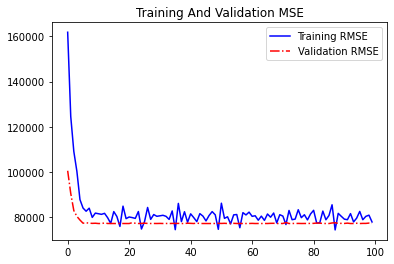

<Figure size 1152x576 with 0 Axes>

In [455]:
visualize_nn(history, model, x_tr, y_tr, x_val, y_val)

# Testing Best Fit Model

In [585]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [586]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=245)

x_tr = transformer.fit_transform(x_tr)
x_val = transformer.transform(x_val)

rfe = RFE(LinearRegression(normalize=False), n_features_to_select=80)
x_tr = rfe.fit_transform(x_tr, y_tr)
x_val = rfe.transform(x_val)

# Fitting Model
model = Ridge(alpha=10.0, max_iter=500, random_state=1000)
results = model.fit(x_tr, y_tr)

# Getting Predictions
y_tr_preds = results.predict(x_tr)
y_val_preds = results.predict(x_val)

In [587]:
get_results_preds(y_tr, y_tr_preds, y_val, y_val_preds)

R-Squared score for the training data: 0.8443560551411233

R-Squared score for the testing data: 0.8625669061039603


Root Mean Squared Error for the training data: 32014.381493841953

Root Mean Squared Error for the testing data: 27146.66162434128


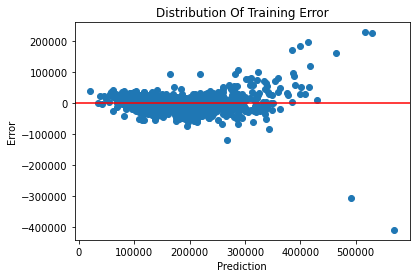

In [588]:
train_error_distribution(y_tr, y_tr_preds)

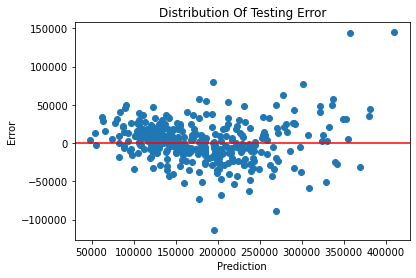

In [589]:
test_error_distribution(y_val, y_val_preds)

# Results

After using grid search to cross validate simple linear regressors, ridge regressors, lasso regressors, decision tree regressors, random forest regressors, and fully connected dense neural networks, the model that appeared to have the best fit in regard to the bias-variance tradeoff was a ridge regressor with alpha = 10.0 and max iterations = 500 as parameters. 

On the training data, this model returned an r-squared score of 0.844 and a root mean squared error score of approximately 32,014. On the validation data, the model returned an r-squared score of 0.863 and a root mean squared error score of approximately 27,146.

## Note: 
Because the test set does not contain a column for sale price, as competitors in the kaggle competition submit their final predictions for scoring, I will not be testing the best model on the test set. However, I've included the code I would use if I was testing the holdout set:

In [553]:
test_df = pd.read_csv('data/test.csv')

In [554]:
test_df = test_df.apply(impute_lot_frontage, axis=1)

In [555]:
replace_NaN(test_df, ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], 'U')

In [556]:
test_df.drop('Id', axis=1, inplace=True)

In [557]:
test_df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [558]:
test_df.drop(['GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF'], axis=1, inplace=True)

In [559]:
test_df.drop(low_var, axis=1, inplace=True)

In [560]:
test_df.drop('MSSubClass', axis=1, inplace=True)

In [561]:
test_df.dropna(inplace=True)

In [562]:
map_function(test_df, ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual'], scale_function)

In [563]:
test_df['Bath_Fireplaces'] = test_df['Fireplaces'] + test_df['FullBath']

In [568]:
x_train = train_df.drop(['SalePrice'], axis=1)
y_train = train_df['SalePrice']

In [566]:
x_test = test_df

In [570]:
x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)

rfe = RFE(LinearRegression(normalize=False), n_features_to_select=80)
x_train = rfe.fit_transform(x_train, y_train)
x_test = rfe.transform(x_test)

# Fitting Best Model
model = Ridge(alpha=10.0, max_iter=500, random_state=1000)
results = model.fit(x_train, y_train)

# Getting Predictions
y_train_preds = results.predict(x_train)
y_test_preds = results.predict(x_test)

In [574]:
get_results_preds(y_train, y_train_preds, y_test, y_test_preds)

R-Squared score for the training data: 0.8509148503685335

Root Mean Squared Error for the training data: 30596.69300007709



In [ ]:
train_error_distribution(y_train, y_train_preds)

In [ ]:
test_error_distribution(y_test, y_test_preds)